In [2]:
import numpy as np
import pandas as pd

import pickle
import re

import networkx as nx
import matplotlib.pyplot as plt
import plotly.express as px

#import osmnx as ox
import geopandas as gpd
#import shapely.geometry

My dataset of the whole of Belfast is too big to experiment with graphing. As I'm mainly interested in Short Strand/Ballymacarrett, I decided derive a smaller and more focused dataset to work with.

Here's an overview of street directories hosted on LennonWylie:
* 1877: Earliest version with street intersections in sequence, Ballymacarrett combined with Belfast, but an additonal [street index](https://lennonwylie.co.uk/1877Appendix.htm#Street%20Index) sometimes notes if a street is in Ballymacarrett (or Mountpottinger) (approx 90 streets)
* 1868: Mountpottinger and Lagan Village are included in Ballymacarrett at https://lennonwylie.co.uk/ballymacarrett1868.htm, separately from Belfast. It includes 14 intersections and usually includes street parts (Rows, Terraces, Places) on their parent streets.
* 1861: Ballymacarrett is separate but mostly lacking intersection data (only four streets have it).
* 1852: Ballymacarrett is separate and has no intersection data but a lot of small rows.

I considered various ways of extracting the subset of data from the available sources, including:
* scraping the html of the 1868 edition with BeautifulSoup (there is slightly more context in the html than the text copy but not much as it uses non-hierarchical and non-standard formatting)
* editing my original extraction algorithm to make use of the "edge case" where extra lines after some street names indicate that the streets are in Ballymacarrett, storing this exta data to filter the dataset (ultimately unsuccessful, also due to inconsistent formatting)
* building a list of streets to filter for, based on data from the streets list in the 1877 directory, which is not separated by area but simpler in format.

The final option was ultimately the one that worked.

# Filter whole 1877 data based on area from separate street list

To filter the data, I first built a list of target streets (streets in the areas I am interested in) from the separate streets list in the directory. The streets list is not separated by areas in 1877 as it was in previous editions, but areas are often mentioned next to street names, albeit somewhat irregularly. Due to the simpler formatting, it is easier to use an algorithm to look for them based on a few rules including `target_areas = ['Mountpottinger', 'Ballymacarrett', 'Lagan Village']`. 

When I first tried to combine this new streets dataframe with my main data, I discovered that the main detection needed further refining, as most of the "edge cases" were in fact in my target data and were limiting its size and therefore usefulness. Once that was fixed, I was able to filter the main data based on my dataframe of target streets.

## Get street list as a DataFrame

From the streets list, I used some rules to detect which 1877 streets were in the target areas. These are stored in `df_ballymac_streets` along with the area and the adjoining street if these were detected.

There were a few more anomolies to solve in this stage:
* Streets names such as 'Bridge End' are sometimes also used as area names, e.g. `Memel Street, Bridge End`
* Consequently, some streets have ambiguous street and area names, e.g. `Donegore Street, Bridge End, Ballymacarrett` vs `Graham's Place, Ballymacarrett, Bridge End` (Ballymacarrett/Ballymacarrett Road is listed in the main directory as a street in its own right, though doesn't have its own entry in the streets list.) #TODO: find name change
* An error from the original source in which 'Short Strand' intersections are sometimes given as 'Short Street', which is a different street in Belfast, e.g. `Independent Street, Ballymacarrett, Short Street` (confirmed after some confusion by looking at a map).

In [3]:
# first, def the street name standardiser:
def transform_street_names(df):
    # copy input to new df to leave original unchanged
    df_transformed = df.copy()
    
    def transform_street(street):
        if pd.isna(street):
            return street
        
        # find and move '(back)' or '(Back)'
        if '(back)' in street.lower():
            street = re.sub(r'\(back\)|\(Back\)', '', street, flags=re.IGNORECASE).strip() + ' Back'

        # don't modify streets called simply eg "North Street"
        words = street.split()
        if len(words) < 3:
            return street
        
        # modify streets starting with specified qualifiers
        else:
            qualifiers = ['North', 'South', 'East', 'West', 'Great', 'Little', 'Upper', 'Lower', 'New', 'Old']
            
            for qualifier in qualifiers:
                if street.startswith(qualifier):
                    return street[len(qualifier):].strip() + ' ' + qualifier
            
            return street.strip()
    
    # apply transformation to columns
    df_transformed['street'] = df_transformed['street'].apply(lambda x: transform_street(str(x)) if not pd.isna(x) else np.nan)
    if 'second_street' in df_transformed.columns:
        df_transformed['second_street'] = df_transformed['second_street'].apply(lambda x: transform_street(str(x)) if not pd.isna(x) else np.nan)

    return df_transformed


In [4]:
# function to ingest target ares from street list txt file
def get_ballymac_streets(file_path_streetlist_txt):
    with open(file_path_streetlist_txt) as file:
        txt_file = file.readlines()

    df_street_gather = pd.DataFrame(columns=['street', 'area', 'second_street'])
    target_areas = ['Mountpottinger', 'Ballymacarrett', 'Lagan Village', 'Bridge End']
    
    # split the lines at commas into street, (area,) and second_street as df columns and append
    for line in txt_file:
        if ',' in line and any(area in line for area in target_areas):
            parts = line.split(',', 2)
            if len(parts) == 3:
                street, part1, part2 = map(str.strip, parts) # LATER: check usage of map(), found online

                if part1 in target_areas and part2 =='Ballymacarrett':
                    area, second_street = part2, part1
                elif part1 in target_areas and part2 in target_areas:
                    area, second_street = part1, part2
                elif part1 in target_areas:
                    area, second_street = part1, part2
                elif part2 in target_areas:
                    area, second_street = part2, part1
                else:
                    area, second_street = '', f"{part1}, {part2}"                
                df_street_gather.loc[len(df_street_gather)] = [street, area, second_street]
            
            elif len(parts) == 2:
                street, part1 = parts
                part1 = part1.strip()
                
                if part1 in target_areas:
                    area, second_street = part1, ''
                else:
                    area, second_street = '', part1                
                df_street_gather.loc[len(df_street_gather)] = [street.strip(), area, second_street]
    
    # standardise street names
    df_street_gather = transform_street_names(df_street_gather)

    # clean up peculiar df abbreviations and errors to enable matching (LATER: clean code up!)
    for index, row in df_street_gather.iterrows():
        street = row['street'].replace('Terr.', 'Terrace')

        df_street_gather.at[index, 'street'] = street

        second_street_parts = row['second_street'].replace('Short Street', 'Short Strand').split()
        for i, part in enumerate(second_street_parts):
            if part.endswith(('Rd', 'Rd.')):
                second_street_parts[i] = part.replace('Rd', 'Road').replace('Rd.', 'Road')
            elif part == "N'Ards":
                second_street_parts[i] = "Newtownards"
        second_street = ' '.join(second_street_parts).replace('.', '')

        if second_street.endswith(('St', 'St.')) and len(second_street_parts) == 1:
            second_street = second_street[:-2] + 'Street'

        df_street_gather.at[index, 'second_street'] = second_street

        #detect three words ending 'Street' or 'Road' with the first word matching any of target_areas
        second_street_parts = second_street.split()
        if len(second_street_parts) == 3 and \
                second_street_parts[0] in target_areas and \
                second_street_parts[-1].endswith(('Street', 'Road')):
            area = second_street_parts[0]
            second_street = ' '.join(second_street_parts[1:])
            
            df_street_gather.at[index, 'area'] = area
            df_street_gather.at[index, 'second_street'] = second_street

        #add missing streets that appear only as second_street 
        if second_street:
            new_street = second_street[4:] if second_street.startswith('see ') else second_street
            new_second_street = '' if second_street.startswith('see ') else street
            if not (((df_street_gather['street'] == new_street) & (df_street_gather['second_street'] == new_second_street)).any() \
                    or ((df_street_gather['street'] == new_street) & (new_second_street == '')).any()):
                df_street_gather.loc[len(df_street_gather)] = [new_street, row['area'], new_second_street]
    
    # second pass, and now try not to cross a bridge!
    for line in txt_file:
        if ',' in line and not ', The' in line and any(target_street in line for target_street in df_street_gather['street']):
            parts = line.split(',', 2)
            if not parts[1] == 'Bridge':
                if len(parts) == 3:
                    street, part1, part2 = map(str.strip, parts) # LATER: check usage of map(), found online

                    if part1 in target_areas and part2 =='Ballymacarrett':
                        area, second_street = part2, part1
                    elif part1 in target_areas and part2 in target_areas:
                        area, second_street = part1, part2
                    elif part1 in target_areas:
                        area, second_street = part1, part2
                    elif part2 in target_areas:
                        area, second_street = part2, part1
                    else:
                        area, second_street = '', f"{part1}, {part2}"                
                    df_street_gather.loc[len(df_street_gather)] = [street, area, second_street]
                
                elif len(parts) == 2:
                    street, part1 = parts
                    part1 = part1.strip()
                    
                    if part1 in target_areas:
                        area, second_street = part1, ''
                    else:
                        area, second_street = '', part1                

        if not (df_street_gather['street'] == street).any():
            df_street_gather.loc[len(df_street_gather)] = [street, area, second_street]

        #TODO: maybe again add missing streets that appear only as second_street - but probaby not as we are already out of range! check after avoiding bridges
    
    #second clean    
    for index, row in df_street_gather.iterrows():
        street = row['street'].replace('Terr.', 'Terrace')

        df_street_gather.at[index, 'street'] = street

        second_street_parts = row['second_street'].replace('Short Street', 'Short Strand').split()
        for i, part in enumerate(second_street_parts):
            if part.endswith(('Rd', 'Rd.')):
                second_street_parts[i] = part.replace('Rd', 'Road').replace('Rd.', 'Road')
            elif part == "N'Ards":
                second_street_parts[i] = "Newtownards"
        second_street = ' '.join(second_street_parts).replace('.', '')

        if second_street.endswith(('St', 'St.')) and len(second_street_parts) == 1:
            second_street = second_street[:-2] + 'Street'

        df_street_gather.at[index, 'second_street'] = second_street

        #detect three words ending 'Street' or 'Road' with the first word matching any of target_areas
        second_street_parts = second_street.split()
        if len(second_street_parts) == 3 and \
                second_street_parts[0] in target_areas and \
                second_street_parts[-1].endswith(('Street', 'Road')):
            area = second_street_parts[0]
            second_street = ' '.join(second_street_parts[1:])
            
            df_street_gather.at[index, 'area'] = area
            df_street_gather.at[index, 'second_street'] = second_street
    
    # standardise street names
    df_street_gather = transform_street_names(df_street_gather)
    df_street_gather.drop_duplicates(keep='first', inplace=True, ignore_index=True) #quick fix - LATER: avoid duplicates above or only use drop

    return df_street_gather

# apply function to streets-only txt file 
df_ballymac_streets = get_ballymac_streets('./data/1877-BSD-streets-only')


In [5]:
df_ballymac_streets.to_csv('./data/df_ballymac_streets.csv')
df_ballymac_streets


,street,area,second_street
0,Abercorn Cottages,Ballymacarrett,
1,Albert Bridge Road,Mountpottinger,
2,Alfred Terrace,,see Mountpottinger Road
3,Ashley Lodge,Ballymacarrett,see Newtownards Road
4,Ashley Place,Mountpottinger,see Albert bridge Road
...,...,...,...
255,Willowfield,,see Woodstock Road
256,Willowfield Place,,see Woodstock Road
257,Woodstock Place,,Woodstock Road
258,Woodstock Street,,Albert Bridge Road


## Main data detection (new and improved)

The main extraction algorithm needed more rules adding to it to get around irregularities in the directory. These include specific streets listed with alternate names, eg. use 'Ballynafeigh' intead of 'Ballynafoy' or both, as listed in street list (present in two roads - New and Old). The changes also fixed the detection of intersections that were not marked in the text by 'Off ' or ' to '

In [6]:
def bsd_txt_to_df_basic_nodes_2(txt_file_path):
    with open(txt_file_path) as file:
        txt_file = file.readlines()

    df_node_gather = pd.DataFrame(columns=['street', 'side', 'node_info', 'node_type'])
    current_street = node_info = side = node_type = ''
    i = 0 

    while i < len(txt_file):
        line = txt_file[i]
        next_line = txt_file[i + 1] if i + 1 < len(txt_file) else ''  # with EOF protection
        prev_line = txt_file[i - 1] if i - 1 >= 0 else ''

        # store explicit intersections as nodes and mark them as such
        if 'intersect' in line.lower():
            node_info = line.strip(".").replace(' intersects', '').replace(' intersect', '').replace('\n', '')
            node_type = 'intersect'

        # detect street renaming and skip #LATER: store if working over multiple years' directories
        elif line.strip() == '' or line.startswith('[Late ') or line.startswith('(Late ') or line.startswith('Late '):
            i += 1
            continue

        # crude detect lines only denoting side of street even when not directly under street
        elif ']' in line:
            side = line.strip()
            i += 1
            continue
        
        else:
            # detect street header based on line and next line contents
            if prev_line.strip() == '' and len(line.split()) < 6 and not '[' in line and not ' to ' in line and not 'intersect' in line \
                and not any(char.isdigit() for char in line) and not "__" in line \
                and (' to ' in next_line or next_line.startswith('Off ') or next_line.startswith('From ') 
                     or '[' in next_line or 'Road' in next_line or 'Street' in next_line 
                     or ', Ballymacarrett' in next_line or next_line.strip() == 'Mountpottinger' 
                     or next_line.strip() == 'Ballymacarrett' or next_line.strip() == '') \
                and not 'door to' in next_line and not '.......' in next_line and not 'entrance to' in next_line.lower():

                    current_street = line.strip().replace(', Ballymacarrett', '')
                    side = ''  # reset side when beginning a new street
                    
                    # solve extra line for district or side: skip it and get node info from line below
                    if next_line.strip() == 'Mountpottinger' or next_line.strip() == 'Ballymacarrett': 
                        next_line = txt_file[i + 2]
                        i += 1
                    elif ']' in next_line:
                        side = next_line.strip()
                        next_line = txt_file[i + 2]
                        i += 1

                    i += 1  # increment i an extra time to avoid processing next_line a second time as line

            # detect sub-street stub entries and store
            if next_line.strip().startswith('See '):
                current_street = next_line.strip().replace('See ', '').replace(', Ballymacarrett', '')
                node_info = line.strip().replace(', Ballymacarrett', '')
                node_type = 'sub-street'

            # otherwise look for from-to info based on the street line and the following line
            elif (' to ' in next_line or next_line.strip().startswith('Off ') or next_line.strip().startswith('From ') \
                or 'Road' in next_line or 'Street' in next_line) \
                and not 'door to' in next_line and not 'entrance to' in next_line.lower() and not '....' in next_line\
                and not any(char.isdigit() for char in line) and not any(char.isdigit() for char in next_line):
                node_info = next_line.strip()
                #(also store 'off' as from-to for now, and process it later)
                node_type = 'from-to'

            # store and mark next lines that may be an intersecting street or may just mean the vicinity of a street
            elif next_line.strip().endswith(', Ballymacarrett') and 'Baltic' in line:
                node_info = next_line.strip().replace(', Ballymacarrett', '')
                node_type = 'vicinity'

            else:
                node_info = line.strip()

        df_node_gather.loc[len(df_node_gather)] = {
            'street': current_street,
            'side': side,
            'node_info': node_info,
            'node_type': node_type
        }

        # reset per-record variables and increment
        node_info = node_type = ''
        i += 1
    
    #TODO: make into 'fix street errors' function. and add correction maybe: ravenhill and lagan village road;
    df_node_gather['street'] = df_node_gather['street'].str.replace('Ballynafeigh or Ballynafoy ', 'Ballynafeigh ').str.replace('Ballynafoy ', 'Ballynafeigh ').str.replace("Graham's Open", "Graham's Place")
    df_node_gather = transform_street_names(df_node_gather)

    return df_node_gather

df_basic_nodes_2 = bsd_txt_to_df_basic_nodes_2('./data/1877-BSD')


Now the 'vicinity' rows needed to be manually inspected to see if the attempted distinction was useful. Using the original definition (the next line ends ', Ballymacarrett') only six items were marked, of which half were are actually intersections (at Abercorn Basin, Graham's Place, and Laganview Street) and a further item 'Loop Bridge' is ambiguous (but does not appear as a street in its own right so including it is not detrimental). Therefore, as a workaround I modified the dectection to directly exclude only the two 'Baltic' streets.

In [7]:
df_basic_nodes_2[df_basic_nodes_2['node_type'] == 'vicinity']

,street,side,node_info,node_type
2832,Baltic Street,,Bridge End,vicinity
2866,Baltic Street East,,Bridge End,vicinity


In [8]:
df_basic_nodes_2.to_csv('./data/df_basic_nodes_2.csv')

Now I need to carry out some transformation steps to derive a dataframe `df_nodes_2` with the node data properly separated into columns, modifying my prevous approach based on the format of the new data gathered in `df_basic_nodes_2`. This includes:
* adding a row at the end each street listed as 'from' and 'to' other streets, to represent its connection to the 'to' street
* separating out multiple streets listed on the same line (multi-way intersections), for example `Mayne Street, Sturgeon Street, Watson Street, Beggs Street and McGahen Street intersect`
* extracting the door number of each address

In [9]:
# distinguish different types of street connections (ignoring sub-street and vicinity for now)
df_connections = df_basic_nodes_2[df_basic_nodes_2['node_type'].isin(['intersect', 'from-to'])][['street', 'node_type', 'node_info']]
df_connections[['from', 'to']] = df_connections['node_info'].str.split(' to ', n=1, expand=True)
df_connections['from'] = df_connections['from'].str.replace('Off ', '')
df_connections['node_type'] = df_connections.apply(lambda row: 'off' if row['node_info'].startswith('Off ') else row['node_type'], axis=1)
df_nodes_2 = df_basic_nodes_2.join(df_connections[['node_type', 'from', 'to']], lsuffix='_old')
df_nodes_2.drop(columns=['node_type_old'], inplace=True)

# add an extra flipped from-to node at the end of each street group
def add_second_from_to_node(grouped_street):
    if 'from-to' in grouped_street['node_type'].values:
        from_to_row = grouped_street[grouped_street['node_type'] == 'from-to'].iloc[0].copy()
        from_to_row['from'] = None
        from_to_row['node_type'] = 'from-to-inverse'
        grouped_street.loc[grouped_street['node_type'] == 'from-to', 'to'] = None
        grouped_street = pd.concat([grouped_street, from_to_row.to_frame().transpose()], ignore_index=True)
    return grouped_street

df_nodes_2 = df_nodes_2.groupby('street').apply(add_second_from_to_node).reset_index(drop=True)

# also store the intersecting street (from either 'from' or 'to') in a new unified single column
df_nodes_2['second_street'] = df_nodes_2['from'].combine_first(df_nodes_2['to'])
# add a step to deal with non-street info after a comma (eg area), but retain unnamed or multiple streets
df_nodes_2['second_street'] = df_nodes_2['second_street'].apply(lambda x: x.split(',')[0] if isinstance(x, str) \
                                                                and 'named' not in x and ' and ' not in x else x)

# get rows with multiple streets in 'second_street' and split to list values
df_nodes_test_2 = df_nodes_2.copy()
df_multi_streets = df_nodes_test_2[df_nodes_test_2['second_street'].fillna('').str.contains(' and ')].copy()
df_multi_streets['second_street'] = df_multi_streets['second_street'].str.split(' and |, ')

# rename street items ending in "Streets"
def process_list(lst):
    return [item.replace(" Streets", "").strip() + " Street" for item in lst]

df_multi_streets['second_street'] = df_multi_streets['second_street'].apply(lambda x: process_list(x) if any(" Streets" in item for item in x) else x)

# iterate through 'multi' rows and derive new separate rows
new_rows = []
for index, row in df_multi_streets.iterrows():
    for street in row['second_street']:
        new_row = row.copy()
        new_row['second_street'] = street
        new_rows.append(new_row)

# drop original 'multi' street rows from main data set
df_nodes_test_2.drop(df_multi_streets.index, inplace=True)

# convert new rows to a df and concat with main data set
new_df = pd.DataFrame(new_rows)
df_nodes_test_2 = pd.concat([df_nodes_test_2, new_df]) #, ignore_index=True

# sort by index to ensure sequential order then reset
df_nodes_test_2.sort_index(inplace=True)
df_nodes_test_2.reset_index(inplace=True, drop=True)

# extract door number #LATER: handle multiple and insert new rows in sequence order (currently only the first number listed is used)
df_nodes_test_2['door_number'] = df_nodes_test_2['node_info'].copy().str.replace('½', '.5').str.extract(r'(\d+(?:\.\d+)?)')

# handle ditto (") door number - use value from the previous row
for i in range(1, len(df_nodes_test_2)):
    if df_nodes_test_2.loc[i, 'node_info'].strip().startswith('"'):
        df_nodes_test_2.loc[i, 'door_number'] = df_nodes_test_2.loc[i - 1, 'door_number']

df_nodes_test_2


/tmp/ipykernel_97874/1290790078.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_nodes_2 = df_nodes_2.groupby('street').apply(add_second_from_to_node).reset_index(drop=True)


,street,side,node_info,node_type,from,to,second_street,door_number
0,Abbey Street,,North King Street to Peter's Hill,from-to,North King Street,None,North King Street,NaN
1,Abbey Street,,"1. Donaldson, Wm.",NaN,NaN,NaN,NaN,1
2,Abbey Street,,"3. Craggan, John, musician",NaN,NaN,NaN,NaN,3
3,Abbey Street,,"5. Ireland, Alex., flax dresser",NaN,NaN,NaN,NaN,5
4,Abbey Street,,"7. Long, John",NaN,NaN,NaN,NaN,7
...,...,...,...,...,...,...,...,...
38969,Zetland Street,,"8. Clarke, James, her Majesty's Court of Probate",NaN,NaN,NaN,NaN,8
38970,Zetland Street,,"6. Morrow, Mrs.",NaN,NaN,NaN,NaN,6
38971,Zetland Street,,"4. Lynas, Joseph, boot maker",NaN,NaN,NaN,NaN,4
38972,Zetland Street,,"2. Fleming, James, insurance agent",NaN,NaN,NaN,NaN,2


More steps are needed to correct 'second_street' at this stage, as I want to leave the original node_info unchanged.

In [10]:
df_nodes_test_2['second_street'] = df_nodes_test_2['second_street'].str.replace('Ballynafeigh or Ballynafoy ', 'Ballynafeigh ').str.replace('Ballynafoy ', 'Ballynafeigh ').str.replace("Graham's Open", "Graham's Place")
df_nodes_test_2['from'] = df_nodes_test_2['from'].str.replace('Ballynafeigh or Ballynafoy ', 'Ballynafeigh ').str.replace('Ballynafoy ', 'Ballynafeigh ').str.replace("Graham's Open", "Graham's Place")
df_nodes_test_2['to'] = df_nodes_test_2['to'].str.replace('Ballynafeigh or Ballynafoy ', 'Ballynafeigh ').str.replace('Ballynafoy ', 'Ballynafeigh ').str.replace("Graham's Open", "Graham's Place")


In [11]:
df_nodes_2 = df_nodes_test_2.copy()
df_nodes_2

,street,side,node_info,node_type,from,to,second_street,door_number
0,Abbey Street,,North King Street to Peter's Hill,from-to,North King Street,None,North King Street,NaN
1,Abbey Street,,"1. Donaldson, Wm.",NaN,NaN,NaN,NaN,1
2,Abbey Street,,"3. Craggan, John, musician",NaN,NaN,NaN,NaN,3
3,Abbey Street,,"5. Ireland, Alex., flax dresser",NaN,NaN,NaN,NaN,5
4,Abbey Street,,"7. Long, John",NaN,NaN,NaN,NaN,7
...,...,...,...,...,...,...,...,...
38969,Zetland Street,,"8. Clarke, James, her Majesty's Court of Probate",NaN,NaN,NaN,NaN,8
38970,Zetland Street,,"6. Morrow, Mrs.",NaN,NaN,NaN,NaN,6
38971,Zetland Street,,"4. Lynas, Joseph, boot maker",NaN,NaN,NaN,NaN,4
38972,Zetland Street,,"2. Fleming, James, insurance agent",NaN,NaN,NaN,NaN,2


The data in `df_nodes_2` needs to be further cleaned to handle:
* the inconsistent naming of streets with 'North', 'Upper', 'Back', etc.

In [12]:
df_nodes_2[df_nodes_2['second_street'].str.contains('Graham', na=False)]

,street,side,node_info,node_type,from,to,second_street,door_number
5157,Bridge End,[Left Side],Graham's Open,intersect,Graham's Place,None,Graham's Place,NaN
18531,High Street,,Graham's Entry,intersect,Graham's Entry,None,Graham's Entry,NaN
25414,Middlepath Street,,Graham's Place,intersect,Graham's Place,None,Graham's Place,NaN
30067,Rosemary Street,,Graham's Entry,intersect,Graham's Entry,None,Graham's Entry,NaN


In [13]:
#TODO: check if still needed now done in basic nodes 

In [14]:
df_nodes_2 = transform_street_names(df_nodes_2)

In [15]:
df_nodes_2.to_csv('./data/df_nodes_2.csv')

## Add extra intersections from target area street list

Now I can check the street list DataFrame `df_ballymac_streets` for street intersections that were not detected in the updated main data `df_nodes_2`. First I filter the two dataframes to get only the intersections, beginning with the streets list:

In [16]:
#filter street list df to include only intersections
intersections_ballymac_streets = df_ballymac_streets[(df_ballymac_streets['second_street'] != '') &
    (~df_ballymac_streets['second_street'].str.startswith('see '))]

intersections_ballymac_streets

,street,area,second_street
6,Baltic Street,Ballymacarrett,Bridge End
7,Baltic Street East,Ballymacarrett,Bridge End
10,Beechfield Street,,Mountpottinger Road
15,Bridge End,Ballymacarrett,Queen's Bridge
17,Campbell's Row,Ballymacarrett,Newtownards Road
...,...,...,...
251,Thompson Place,,Thompson Street
252,Trench Street,,Short Strand
257,Woodstock Place,,Woodstock Road
258,Woodstock Street,,Albert Bridge Road


Next is a preview of all 3603 intersections extracted from the main street directory. The true number is much lower as many intersections appear on two streets. Adding new intersections to them from the target area data presents an extra challenge becasue the order of the data points is meaningful in this data set (i.e. it shows what is next to what).

In [17]:
intersections_nodes = df_nodes_2[df_nodes_2['node_type'].notna()]
intersections_nodes

,street,side,node_info,node_type,from,to,second_street,door_number
0,Abbey Street,,North King Street to Peter's Hill,from-to,North King Street,None,King Street North,NaN
53,Abbey Street,,North King Street to Peter's Hill,from-to-inverse,None,Peter's Hill,Peter's Hill,NaN
54,Abbey Street West,,St. Paul Street to Hanna Street,from-to,St. Paul Street,None,St. Paul Street,NaN
60,Abbey Street West,,St. Paul Street to Hanna Street,from-to-inverse,None,Hanna Street,Hanna Street,NaN
61,Abbot Street,,Off Peveril Street,off,Peveril Street,None,Peveril Street,NaN
...,...,...,...,...,...,...,...,...
38959,York Street Little,,Great Patrick Street to Earl Street,from-to-inverse,None,Earl Street,Earl Street,NaN
38960,Young's Place,,Off Newtownards Road,off,Newtownards Road,None,Newtownards Road,NaN
38962,Young's Row,,Off Newtownards Road,off,Newtownards Road,None,Newtownards Road,NaN
38965,Zetland Street,,McClure Street to Gosford Place,from-to,McClure Street,None,McClure Street,NaN


TODO: Either remove or implement this section. Check if these are a) really new (matching issue!) and b) in area

TODO: resolve modifier cleanup - make sure 'from' is always cleaned too. re-do clearning properly!

Below are the 28 intersections from the target areas not found in the main data. However, some of them are caused by the ambiguous use of a street as an area name. This requires a manual check. 

Should be in the data but are not:
* Abercorn Basin x Queen's Quay: street directory: true; nodes:
* Albert bridge Road x Lord Street (misspelled)
* Conswater Street	x	Newtownards Road (misspelled)
* Claremont Lane	x	Malcolm Lane
* Newtownards Road	x	Trainview
* Sheaby's Yard	x	Middlepath Street


In [18]:
#check street list intersections for new street combinations not found in main data
new_street_combinations = intersections_ballymac_streets[
    ~intersections_ballymac_streets.apply(lambda row: (
        ((intersections_nodes['street'] == row['street']) & 
         (intersections_nodes['second_street'] == row['second_street'])) |
        ((intersections_nodes['street'] == row['second_street']) & 
         (intersections_nodes['second_street'] == row['street']))
    ).any(), axis=1)
]

new_street_combinations.sort_values(by='street')

,street,area,second_street
167,Abercorn Basin,,Queen's Quay
148,Albert bridge Road,Ballymacarrett,Lord Street
6,Baltic Street,Ballymacarrett,Bridge End
7,Baltic Street East,Ballymacarrett,Bridge End
112,Bridge End,Ballymacarrett,Baltic Street
113,Bridge End,Ballymacarrett,Baltic Street East
20,Castlereagh Road,Ballymacarrett,Loop Bridge
150,Claremont Lane,Ballymacarrett,Malcolm Lane
31,Club Row Upper,Ballymacarrett,Short Strand
190,Conswater Street,,Newtownards Road


TODO: (improvement to index numbering system) do this earier in the df before generating the graph in order to assign sequential numbers. Possibly appy to all data before area filtering.

TODO: make work or clear up method for inserting these new intersections in the correct order

In [19]:
for index, row in intersections_ballymac_streets.iterrows():
    street = row['street']
    second_street = row['second_street']
    
    # Check if the intersection combination already exists in main data
    intersection_exists = (
        ((intersections_nodes['street'] == street) & (intersections_nodes['second_street'] == second_street)) |
        ((intersections_nodes['street'] == second_street) & (intersections_nodes['second_street'] == street))
    ).any()

    if not intersection_exists:
        # Find the first occurrence index of the 'street'
        first_occurrence_index = intersections_nodes[intersections_nodes['street'] == street].index.min()
        
        # If 'street' is not found, insert at the end
        if pd.isna(first_occurrence_index):
            first_occurrence_index = len(intersections_nodes)
            # Use a new index value larger than any existing index to append at the end
            new_index = intersections_nodes.index.max() + 1
        else:
            # Insert new row immediately after the first occurrence
            new_index = first_occurrence_index + 0.5
        
        # Create a new row with the missing intersection
        new_row = pd.DataFrame({
            'street': [street],
            'second_street': [second_street]
        }, index=[new_index])
        
        # Append the new row to the DataFrame and sort by index to retain the original order
        intersections_nodes = pd.concat([intersections_nodes, new_row])
        intersections_nodes = intersections_nodes.sort_index()

intersections_nodes

,street,side,node_info,node_type,from,to,second_street,door_number
0.0,Abbey Street,,North King Street to Peter's Hill,from-to,North King Street,None,King Street North,NaN
53.0,Abbey Street,,North King Street to Peter's Hill,from-to-inverse,None,Peter's Hill,Peter's Hill,NaN
54.0,Abbey Street West,,St. Paul Street to Hanna Street,from-to,St. Paul Street,None,St. Paul Street,NaN
60.0,Abbey Street West,,St. Paul Street to Hanna Street,from-to-inverse,None,Hanna Street,Hanna Street,NaN
61.0,Abbot Street,,Off Peveril Street,off,Peveril Street,None,Peveril Street,NaN
...,...,...,...,...,...,...,...,...
38980.0,Abercorn Basin,NaN,NaN,NaN,NaN,NaN,Queen's Quay,NaN
38981.0,Conswater Street,NaN,NaN,NaN,NaN,NaN,Newtownards Road,NaN
38982.0,George Street Little,NaN,NaN,NaN,NaN,NaN,York Street,NaN
38983.0,Parkview,NaN,NaN,NaN,NaN,NaN,"Ravenhill, see Ballynafeigh Road Old",NaN


# Filter main data set for target area only

The goal of creating this smaller data set, as stated is to provide a smaller amount of contiguous data to test out graphing approaches, as the whole city data set was too large for this. Now that I have a list of streets for the target areas, I can filter the main node data for the whole city based on this list.

A check shows that the corrections to the detection algorithm have produced about one-third more nodes.

In [20]:
df_nodes_ballymac_2 = df_nodes_2[df_nodes_2['street'].isin(df_ballymac_streets['street']) | df_nodes_2['second_street'].isin(df_ballymac_streets['street'])].reset_index()
df_nodes_ballymac_2.to_csv('./data/df_nodes_ballymac_2.csv')
df_nodes_ballymac_2

,index,street,side,node_info,node_type,from,to,second_street,door_number
0,62,Abercorn Basin,,Abercorn Basin,NaN,NaN,NaN,NaN,NaN
1,63,Abercorn Basin,,"1 & 2. Humphrys, L. J., Agent for Wigan Coal a...",NaN,NaN,NaN,NaN,1
2,64,Abercorn Basin,,Ulster Iron Works,NaN,NaN,NaN,NaN,NaN
3,65,Abercorn Basin,,"MacIlwaine & Lewis, Engineers, Boilermakers an...",NaN,NaN,NaN,NaN,NaN
4,66,Abercorn Basin,,Hamilton Dock House,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3637,38526,Woodstock Street,,"2. Cooke, James, tailor",NaN,NaN,NaN,NaN,2
3638,38960,Young's Place,,Off Newtownards Road,off,Newtownards Road,None,Newtownards Road,NaN
3639,38961,Young's Place,,Ten small houses,NaN,NaN,NaN,NaN,NaN
3640,38962,Young's Row,,Off Newtownards Road,off,Newtownards Road,None,Newtownards Road,NaN


The following of which are intersections:

In [21]:
df_nodes_ballymac_intersections = df_nodes_ballymac_2[df_nodes_ballymac_2['second_street'].notna()]
df_nodes_ballymac_intersections

,index,street,side,node_info,node_type,from,to,second_street,door_number
9,608,Albert Bridge Road,,Albert Bridge to Ballymacarrett Road,from-to,Albert Bridge,None,Albert Bridge,NaN
25,624,Albert Bridge Road,,Woodstock Road,intersect,Woodstock Road,None,Woodstock Road,NaN
46,645,Albert Bridge Road,,Malcolm Street,intersect,Malcolm Street,None,Malcolm Street,NaN
58,657,Albert Bridge Road,,Lower Mount Street,intersect,Lower Mount Street,None,Mount Street Lower,NaN
67,666,Albert Bridge Road,,Mount Street,intersect,Mount Street,None,Mount Street,NaN
...,...,...,...,...,...,...,...,...,...
3582,38471,Woodstock Road,,Mount Street,intersect,Mount Street,None,Mount Street,NaN
3615,38504,Woodstock Street,,Off Albert Bridge Road,off,Albert Bridge Road,None,Albert Bridge Road,NaN
3623,38512,Woodstock Street,,Madrid Street,intersect,Madrid Street,None,Madrid Street,NaN
3638,38960,Young's Place,,Off Newtownards Road,off,Newtownards Road,None,Newtownards Road,NaN


To get an inital overview of the connections, I plotted a network graph of only the intersections. In this graph, each node represents a whole street, and the edges show all of its connections to other streets.

/tmp/ipykernel_97874/4041221681.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  binary_matrix = pd.crosstab(df['street'], df['second_street']).applymap(lambda x: 1 if x > 0 else 0)


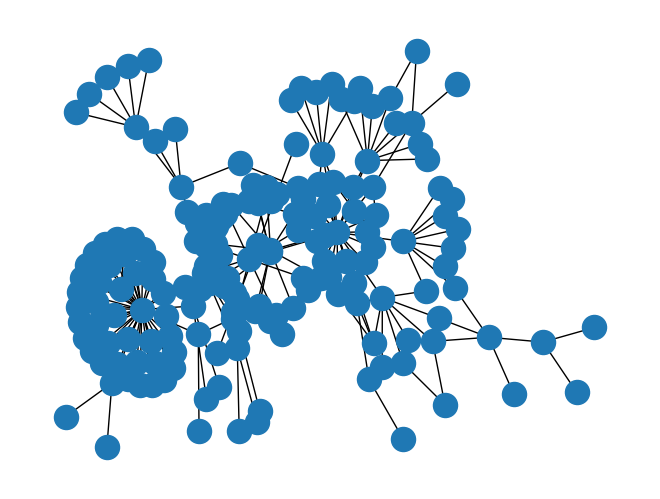

In [22]:
df = df_nodes_ballymac_intersections

all_streets = pd.unique(df[['street', 'second_street']].values.ravel())  
binary_matrix = pd.crosstab(df['street'], df['second_street']).applymap(lambda x: 1 if x > 0 else 0)

# ensure square matrix
binary_matrix = binary_matrix.reindex(index=all_streets, columns=all_streets, fill_value=0)

G = nx.from_pandas_adjacency(binary_matrix)

# draw
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=False)


In [23]:
import plotly.graph_objects as go
import networkx as nx

# Get the degree (number of connections) for each node
node_connections = dict(G.degree())

# Create edge traces for the plot
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)  # Breaks between edges
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Create node traces
node_x = []
node_y = []
node_color = []
node_hover_text = []

annotations = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    # Color based on number of connections
    node_color.append(node_connections[node])
    
    # Hover text for all nodes
    node_hover_text.append(f"{node}: {node_connections[node]} connections")
    
    # Add annotations for nodes with 4 or more connections
    if node_connections[node] >= 4:
        annotations.append(
            dict(
                x=x, y=y,  # Position of the label
                text=node,  # Label text (street name)
                showarrow=False,
                xanchor='center',
                yanchor='middle',
                font=dict(size=12, color='black')  # Customize label font
            )
        )

# Define the node trace with correct coloring and hover info for all nodes
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    text=node_hover_text,  # Add hover labels for all nodes
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=10,  # Adjust node size
        color=node_color,  # Color based on node connections
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        )))

# Create the figure and add annotations
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='<br>Network graph',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=0),
                    annotations=annotations,  # Add permanent annotations
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)
                ))

# Show the interactive plot
fig.show()


# TODO: Geocoding

(move this step here for ease of use, add landmarks from historical data)

In [24]:
##TODO: finish adapting to df. change into function that takes a df and only doesintersections in it. fix intersections from streets df first though.

# from geopy.geocoders import GoogleV3

# with open('./data/api_key_googlemaps', 'r') as keyfile:
#     api_key = keyfile.read()

# geolocator = GoogleV3(api_key)

# def geocode_intersection_2(node_df):
#     location = geolocator.geocode(
#         node_df['street'] + " & " + node_df['second_street'] 
#         + ", Belfast, UK",
#         components={"type": "intersection"})
#     if location and 'intersection' in location.raw.get('types', []):
#         return (location.latitude, location.longitude)
#     return None

# if 'coordinates' not in df_nodes_ballymac_2.columns:
#     df_nodes_ballymac_2['coordinates'] = None

# for index, row in df_nodes_ballymac_2.iterrows():
#     if 'second_street' in row and not pd.isna(row['second_street']):
#         coord = geocode_intersection_2(row)
#         if coord:
#             df_nodes_ballymac_2.at[index, 'coordinates'] = coord 

# Add coordinates from historical geodata sources

The Public Records Office of Northern Ireland (PRNOI) and other public sources provide data sets on heritage sites with coordinates attached (as a geojson, shapefile or plain list). These include the [Industrial Heritage Record](https://admin.opendatani.gov.uk/dataset/industrial-heritage-record) which might be able to provide the co-ordinates of some former buildings in the Street Directory data.

In [25]:
gdf_industrial_hr = gpd.read_file('/data/Industrial Heritage Record Clipped.geojson')

DataSourceError: /data/Industrial Heritage Record Clipped.geojson: No such file or directory

# --BREAK HERE-- #

# NetworkX Graph object

In [ ]:
#add the inital nodes, link adjacent nodes on the same street, store second street for intersections
G = nx.Graph()

for index, row in df_nodes_ballymac_2.iterrows():
    street = row['street']
    node_type = row['node_type']
    node_info = row['node_info']
    second_street = row['second_street']
    node_id = f"{street}_{index}" #add a descriptive unique node id - use original (whole city) index in case of future combination of data
    G.add_node(node_id, street=street, node_type=node_type, second_street=second_street)

    # connect adjacent nodes on the same street
    if index > 0 and df_nodes_ballymac_2.at[index - 1, 'street'] == street:
        prev_node_id = f"{street}_{index-1}"
        G.add_edge(node_id, prev_node_id, street=street)

df_edges = nx.to_pandas_edgelist(G)
df_edges

In [ ]:
G.nodes(data=True)

In [ ]:
# add edges joining intersection nodes 
for node in G.nodes(data=True):
    node_id = node[0]
    street = node[1].get('street', '')
    node_type = node[1].get('node_type', '')
    second_street = node[1].get('second_street', '')

    if street == '' or second_street == '':
        continue

    # find and gather nodes with matching 'street' and 'second_street'
    matching_nodes = [n for n, data in G.nodes(data=True) 
                      if n != node_id and
                      data.get('street', '') == second_street and
                      data.get('second_street', '') == street]

    # add edge between matching nodes
    for matching_node in matching_nodes:
        G.add_edge(node_id, matching_node)

df_edges = nx.to_pandas_edgelist(G)
df_edges


## TODO: move up: Geocode intersections

Geocoding returns 75 sets of coordinates with strict filtering for API responses that are intersections. 257 items are found without filtering but the majority are incorrect.

In [ ]:
#note: updated to reject non-intersection API responses - better to do each type separately becasue of Google's over-zealous API

from geopy.geocoders import GoogleV3

with open('./data/api_key_googlemaps', 'r') as keyfile:
    api_key = keyfile.read()

geolocator = GoogleV3(api_key)

def geocode_intersection_2(node_attrs):
    location = geolocator.geocode(node_attrs['street'] + " & " + node_attrs['second_street'] + ", Belfast, UK", components={"type":"intersection"})
    if location and 'intersection' in location.raw.get('types', []):
        return (location.latitude, location.longitude)

for node_key, df_row in G.nodes(data=True):
    if 'second_street' in df_row and not pd.isna(df_row['second_street']):
        coord = geocode_intersection_2(df_row)
        if coord: df_row['coordinates'] = coord 

df_G_nodes = pd.DataFrame.from_dict(G.nodes, orient='index')
df_G_nodes[df_G_nodes['coordinates'].notna()]

SyntaxError: invalid syntax (1696151093.py, line 3)

I check that paired source and destination nodes of "intersection edges"  have the same coordinates, as they should be the same point:

In [ ]:
ls_intersection_edges_with_nodes_coordinates = []

for u, v, d in G.edges(data=True):
    street = d.get('street', '') #TODO: check, clean up
    if street in [None, np.nan, '']:
        u_coords = G.nodes[u].get('coordinates')
        v_coords = G.nodes[v].get('coordinates')
        
        # add to the list if u and v have coords #TODO: check, clean up
        if u_coords is not None or v_coords is not None: 
            ls_intersection_edges_with_nodes_coordinates.append((u, v, d, u_coords, v_coords))

df_intersection_edges_with_nodes_coordinates = pd.DataFrame(ls_intersection_edges_with_nodes_coordinates, 
    columns=['source', 'destination', 'edge_attributes', 'source_coordinates', 'destination_coordinates'])

df_intersection_edges_with_nodes_coordinates

There are some cases where it has not worked, so I transfer the missing coordinates from/to these special edges' source or destination nodes where they are missing.

In [ ]:
for u, v, d in G.edges(data=True):
    street = d.get('street', '')
    if street in [None, np.nan, '']:
        u_coords = G.nodes[u].get('coordinates')
        v_coords = G.nodes[v].get('coordinates')
        
        # add coords from counterpart if missing
        if u_coords is not None or v_coords is not None:
            if u_coords is None:
                G.nodes[u]['coordinates'] = v_coords
            if v_coords is None:
                G.nodes[v]['coordinates'] = u_coords

TODO: "fold" the roads at this point:

In [ ]:
coord_dict = {}

# gather coordinates
for node in G.nodes(data=True):
    node_id = node[0]
    coords = node[1].get('coordinates')
    if coords is not None and not np.isnan(coords).any():
        if coords not in coord_dict:
            coord_dict[coords] = []
        coord_dict[coords].append(node_id)

# add edges between all nodes that share the same coordinates
for nodes in coord_dict.values():
    if len(nodes) > 1:
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                G.add_edge(nodes[i], nodes[j])

I can get an overview of the data using a test plot of intersection coordnates on map:

In [ ]:
df_intersections_test_map=df_G_nodes[df_G_nodes['coordinates'].notna()].copy()
df_intersections_test_map[['Latitude', 'Longitude']] = pd.DataFrame(df_intersections_test_map['coordinates'].tolist(), index=df_intersections_test_map.index)

fig = px.scatter_mapbox(df_intersections_test_map, lat="Latitude", lon="Longitude", hover_name=df_intersections_test_map.index,
                        hover_data={"street": True, "second_street": True, "node_type": True},
                        zoom=10)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

# Experiment with different plots

## Cytoscape (Dash-Cytoscape)

NetworkX has a function (`nx.cytoscape_data(G)`) to convert to a Cytoscape-readable format.

In [ ]:
# Convert NetworkX graph data to Cytoscape-compatible format
cytoscape_data = nx.cytoscape_data(G)
#cytoscape_data['elements']['nodes']

In [ ]:
# make extra modifications due to incorrect coord format
def convert_coordinates_to_position(nodes):
    for node in nodes:
        if 'coordinates' in node['data']:
            if node['data']['coordinates']:
                lat, lon = node['data']['coordinates']
                node['data']['position'] = {'x': lat, 'y': lon}  
    return nodes

cytoscape_data['elements']['nodes'] = convert_coordinates_to_position(cytoscape_data['elements']['nodes'])


Using Cytoscape and Plotly Dash, I was able to plot the streets as strings of nodes. It's beginning to look like streets!

In [ ]:
# TODO: Find a way of combining fixed points and positioning algorithm for the rest

# TODO: I want to assign element classes (if needed) to groups of elements (nodes or edges) based on 'street' for edges and stylesheet selector to automatically style edges in a range of mathematically-assigned palette colors (based on a value derived from 'street') - But for now I was only able to enlarge the intersection nodes.

# TODO: Try to mix preset positions and cose-bilkent

In [ ]:
# #attempt new version from scratch following the docs
# from dash import Dash, html

# import dash_cytoscape as cyto

# app = Dash(__name__)

# app.layout = html.Div([
#     cyto.Cytoscape(
#         id='cytoscape-elements-basic',
#         elements=cytoscape_data['elements'],
#         style={'width': '100%', 'height': '386px'},
#         elements=[



#         ]
#     )
# ])

In [ ]:
cytoscape_data

In [ ]:
from dash import Dash, html
import dash_cytoscape as cyto

app = Dash(__name__)

elements=cytoscape_data['elements']
app.layout = html.Div([
    cyto.Cytoscape(
        id='cytoscape-layout-9',
        elements=elements,
        style={'width': '100%', 'height': '350px'},
        layout={
            'name': 'cose'
        }
    )
])

if __name__ == '__main__':
    app.run(debug=True)

In [ ]:
#fig.write_html("path/to/dash_cytoscape_graph.html")

## Grave - dead vimple graph visualisation

In [ ]:
from grave import plot_network

network = G.copy()

def color_fixed_coord(node_attrs):
    if node_attrs.get('coordinates', True):
        return {'color': 'red'}
    else:
        return {'color': 'black'}

fig, ax = plt.subplots()
plot_network(network, node_style=color_fixed_coord)


# NetworkX plotting

The NetworkX `spring_layout` allows a subset of fixed points - TODO: make that work!

In [ ]:
# create pos attributeas copy of coodinates for proper naming, and to differentiate between nodes with known and derived data later
w = nx.get_node_attributes(G, 'coordinates')
nx.set_node_attributes(G, w, 'pos')

# get only nodes with coordinates
nodes_with_coordinates = [(node, data['coordinates']) for node, data in G.nodes(data=True) if 'coordinates' in data]
fixed_pos = {node: coord for node, coord in nodes_with_coordinates}

# compute center and scale parameters for spring_layout
min_lat, min_lon = 54.57824002300004, -5.87340877594884
max_lat, max_lon = 54.618713694871445, -5.921828013100068

center = ((max_lat + min_lat) / 2, (max_lon + min_lon) / 2)
scale = max(max_lat - min_lat, max_lon - min_lon)

# compute spring layout with fixed positions, center, and scale
spring_pos = nx.spring_layout(G, pos=fixed_pos, fixed=fixed_pos, center=center, scale=scale)

# plot
plt.figure(figsize=(10, 10))

# draw nodes with coordinates (in red and with labels)
nx.draw_networkx_nodes(G, spring_pos, nodelist=[node for node in pos], node_color='red', node_size=300)
nx.draw_networkx_labels(G, spring_pos, labels={node: node for node in pos}, font_size=10, font_color='black')

# draw nodes without coordinates
nx.draw_networkx_nodes(G, spring_pos, nodelist=[node for node in G.nodes if node not in pos], node_color='gray', node_size=5)
nx.draw_networkx_edges(G, spring_pos, edge_color='gray', width=0.5)

plt.title('Street Nework, Belfast 1877 (known positions in red)')
plt.axis('off')
plt.show()

# OSMnx

OSMnx can only be used when all nodes have coordinates. Once I have enough cooordinates I can simplify my graph to only those with coordinates and attempt to use the skipped points as a weighting instead.